
# Weak lensing

This example computes weak lensing maps (convergence and shear) for a redshift
distribution of sources.  The lensing is simulated by a line of sight
integration of the matter fields.


## Setup

Simulate the matter fields, and use them to iteratively compute the lensing
fields.

To obtain the effective integrated lensing maps of a distribution of sources,
the fields from each plane are collected and added with their respective
weights.

The precomputed angular matter power spectra from the :doc:`/basic/shells`
example are used, so the simulation is set up in the same way.  CAMB is also
used further below to compute the theory lensing spectra.



In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

# use the CAMB cosmology that generated the matter power spectra
import camb
from cosmology import Cosmology

# GLASS imports
import glass.shells
import glass.fields
import glass.lensing
import glass.galaxies


# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# basic parameters of the simulation
nside = lmax = 256

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2,
                       NonLinear=camb.model.NonLinear_both)

# get the cosmology from CAMB
cosmo = Cosmology.from_camb(pars)

# shells of 200 Mpc in comoving distance spacing
zb = glass.shells.distance_grid(cosmo, 0., 1., dx=200.)

# uniform matter weight function
ws = glass.shells.tophat_windows(zb)

# load the angular matter power spectra previously computed with CAMB
cls = np.load('cls.npy')

## Matter



In [2]:
# compute Gaussian cls for lognormal fields for 3 correlated shells
# putting nside here means that the HEALPix pixel window function is applied
gls = glass.fields.lognormal_gls(cls, nside=nside, lmax=lmax, ncorr=3)

# generator for lognormal matter fields
matter = glass.fields.generate_lognormal(gls, nside, ncorr=3)

## Lensing



In [3]:
# this will compute the convergence field iteratively
convergence = glass.lensing.MultiPlaneConvergence(cosmo)

## Galaxy



In [4]:
# localised redshift distribution
# the actual density per arcmin2 does not matter here, it is never used
z = np.linspace(0, 1, 101)
dndz = np.exp(-(z - 0.5)**2/(0.1)**2)

## Simulation
The simulation is then straightforward:  Compute the lensing fields for each
shell and add them up using the galaxy densities as a weight.



In [5]:
# the integrated convergence and shear field over the redshift distribution
kappa_bar = np.zeros(12*nside**2)
gamm1_bar = np.zeros(12*nside**2)
gamm2_bar = np.zeros(12*nside**2)

# main loop to simulate the matter fields iterative
for i, delta_i in enumerate(matter):

    # add lensing plane from the window function of this shell
    convergence.add_window(delta_i, ws[i])

    # get convergence field
    kappa_i = convergence.kappa

    # compute shear field
    gamm1_i, gamm2_i = glass.lensing.shear_from_convergence(kappa_i)

    # get the restriction of the dndz to this shell
    z_i, dndz_i = glass.shells.restrict(z, dndz, ws[i])

    # compute the galaxy density in this shell
    ngal = np.trapz(dndz_i, z_i)

    # add to mean fields using the galaxy number density as weight
    kappa_bar += ngal * kappa_i
    gamm1_bar += ngal * gamm1_i
    gamm2_bar += ngal * gamm2_i

# compute the overall galaxy density
ngal = np.trapz(dndz, z)

# normalise mean fields by the total galaxy number density
kappa_bar /= np.sum(ngal)
gamm1_bar /= np.sum(ngal)
gamm2_bar /= np.sum(ngal)

## Analysis
To make sure the simulation works, compute the angular power spectrum of the
simulated convergence field, and compare with the expectation (from CAMB) for
the given redshift distribution of sources.

We are not doing the modelling very carefully here, so a bit of discrepancy is
to be expected.



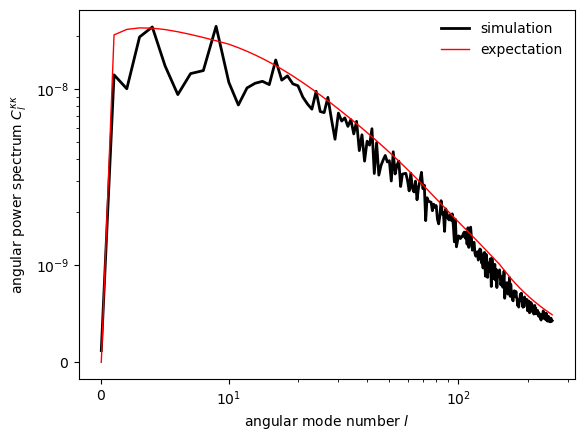

In [6]:
# get the angular power spectra of the lensing maps
sim_cls = hp.anafast([kappa_bar, gamm1_bar, gamm2_bar],
                     pol=True, lmax=lmax, use_pixel_weights=True)

# get the expected cls from CAMB
pars.min_l = 1
pars.set_for_lmax(lmax)
pars.SourceWindows = [camb.sources.SplinedSourceWindow(z=z, W=dndz, source_type='lensing')]
theory_cls = camb.get_results(pars).get_source_cls_dict(lmax=lmax, raw_cl=True)

# get the HEALPix pixel window function, since the lensing fields have it
pw = hp.pixwin(nside, lmax=lmax)

# plot the realised and expected cls
l = np.arange(lmax+1)
plt.plot(l, sim_cls[0], '-k', lw=2, label='simulation')
plt.plot(l, theory_cls['W1xW1']*pw**2, '-r', lw=1, label='expectation')
plt.xscale('symlog', linthresh=10, linscale=0.5, subs=[2, 3, 4, 5, 6, 7, 8, 9])
plt.yscale('symlog', linthresh=1e-9, linscale=0.5, subs=[2, 3, 4, 5, 6, 7, 8, 9])
plt.xlabel(r'angular mode number $l$')
plt.ylabel(r'angular power spectrum $C_l^{\kappa\kappa}$')
plt.legend(frameon=False)
plt.show()